# Notes

[Original Paper](https://arxiv.org/pdf/1912.11035.pdf)

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.model_selection import train_test_split

In [2]:
import torch
from skimage import io
import torchvision
import cv2
from torchvision.transforms import RandomHorizontalFlip, RandomApply, RandomCrop, GaussianBlur, ToTensor, CenterCrop

In [3]:
from torchvision.models import resnet50 
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [6]:
import os
from tqdm import tqdm
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset

In [7]:
torch.cuda.empty_cache()

# Transform

In [8]:
def transform_train(image):
    
    t_1 = RandomHorizontalFlip(p=0.5)
    
    image_1 = t_1(image)
    
    t_2 = RandomApply(transforms = [GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 3))], p=0.1)
    
    image_2 = t_2(image_1)
    
    t_3 = RandomCrop(size=(224,224))
    
    image_3 = t_3(image_2)
    
    choice = [True,False]
    jpeg_choice = random.choices(choice,weights=(10,90))
    
    if jpeg_choice[0]:
        
        quality = random.randint(30,100)

        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        result, encimg = cv2.imencode('.jpg', np.array(image_3), encode_param)
        image_4 = cv2.imdecode(encimg, 1)
        
    else:
        image_4 = image_3
        
    t_n = ToTensor()
    
    image_n = t_n(image_4)
    
    return image_n

In [9]:
def transform_test(image):
    
    t_1 = CenterCrop(size=(224,224))
    
    image_1 = t_1(image)
            
    t_n = ToTensor()
    
    image_n = t_n(image_1)
    
    return image_n

# Dataset, Dataloader

In [10]:
valid_size = .005
batch_size = 64 
num_workers = 2
classes = ["Real", "Fake"]

In [11]:
categories = os.listdir("./progan_train")

start_time_train = time.time()

train_datasets = []
print("Loading Training Data...", flush=True)
for category in tqdm(categories):
    train_datasets.append(datasets.ImageFolder("./progan_train/" + category, transform=transform_train))
    
train_dataset = torch.utils.data.ConcatDataset(train_datasets)

print("Load Time-",round(time.time()-start_time_train,4),"secs")
print("No of images in train dataset=",len(train_dataset))

Loading Training Data...


100%|██████████| 20/20 [00:03<00:00,  5.96it/s]

Load Time- 3.3583 secs
No of images in train dataset= 720119


In [12]:
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                               num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

class_names = train_datasets[0].classes

print("Training Dataloader Length=",len(train_loader))
print("Validation Dataloader Length=",len(valid_loader))

Training Dataloader Length= 11196
Validation Dataloader Length= 57


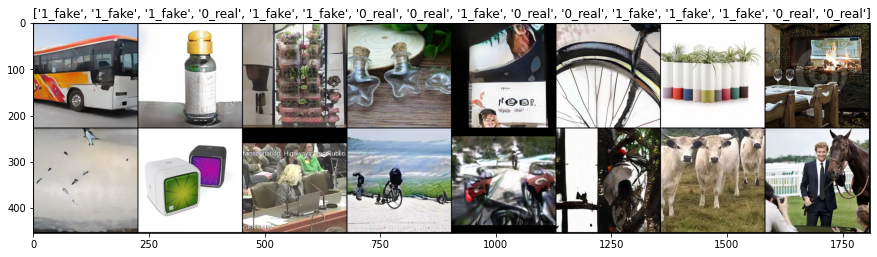

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


plt.figure(figsize=(15,15))
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:16])

imshow(out, title=[class_names[x] for x in classes[0:16]])

# Training, Validation, Testing Loop

In [15]:
def validation_test_loop(device, model, dataloader): 
    
    model=model.eval()
    
    accuracy = 0
    no_of_batches = len(dataloader)
    
    with torch.no_grad():
        for d in dataloader:
            images, labels = d

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            outputs = outputs[:,0]

            correct = ((outputs>=0.5).float() == labels.float())
            acc=torch.sum(correct)/float(len(labels))
            accuracy+=acc.item()
                
    return round(100*accuracy/no_of_batches,4)

In [16]:
def train_loop(device, model, dataloader, val_loader, optimizer, criterion):
    
    start = time.time()
    
    accuracy = 0
    no_of_batches = len(dataloader)
    losses = 0
    model = model.train()
    
    i = 0
    
    train_acc_list=[]
    train_loss_list=[]
    val_acc_list=[]
    
    for d in dataloader:
        images, labels = d
                
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        outputs = outputs[:,0]
        
        loss = criterion(outputs.float(),labels.float())
        
        loss.backward()
        optimizer.step()
        
        correct = ((outputs>=0.5).float() == labels.float())
        acc=torch.sum(correct)/float(len(labels))
                
        accuracy+=acc.item()
        
        losses+=loss.item()
        
        i+=1
        
        
        if(i%1000==0):
            
            val_acc = validation_test_loop(device, model, val_loader)
            train_acc = round(100*accuracy/i,4)
            train_loss = round(losses/i,4)
            
            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)
            val_acc_list.append(val_acc)
            
            model = model.train()
            
            #print("Batch=",i,"/",no_of_batches)
            print("[",i,"/",no_of_batches,"]---Train Accuracy=",train_acc,"Validation Accuracy=",val_acc,"Train Loss=",train_loss)
            print("Time taken=",round((time.time()-start)/60.0,4),"min")
            print("") 

    
    train_acc=round(100*accuracy/no_of_batches,4)
    train_loss=round(losses/no_of_batches,4)
    val_acc = validation_test_loop(device, model, val_loader)
    
    print("Final train accuracy=",train_acc,"%")
    print("Final train loss=",train_loss)
    print("Final validation accuracy=",val_acc,"%")
    
    print("Training Time taken=",round((time.time()-start)/60.0,4),"min")
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    
    return train_acc_list,train_loss_list,val_acc_list, train_loss, val_acc

# Wang 2020 Model

In [17]:
wang_2020_model = torchvision.models.resnet50(pretrained=True)
wang_2020_model.fc = torch.nn.Sequential(torch.nn.Linear(in_features = 2048, out_features = 1), torch.nn.Sigmoid())
wang_2020_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(wang_2020_model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
criterion = torch.nn.BCELoss().to(device)
wang_2020_model = wang_2020_model.to(device)

# Training the model

In [19]:
total_start = time.time()
epochs = 15

train_loss_list_epochs = []
val_acc_list_epochs = []

val_acc_list = []
train_loss_list = []
train_acc_list = []

last_val_acc = 0
flag=False

for i in range(epochs):
    print("================================================Epoch ",i+1," ==================================================")
    
    a,b,c,train_loss,val_acc = train_loop(device, wang_2020_model, train_loader, valid_loader, optimizer, criterion)
    
    train_loss_list_epochs.append(train_loss)
    val_acc_list_epochs.append(val_acc)

    val_acc_list+=c
    train_loss_list+=b
    train_acc_list+=a
    
    if((i+1)%5==0):
          if((val_acc-last_val_acc)<=0.001*last_val_acc):
                
                print("Learning Rate changed ",learning_rate,"----->",learning_rate/10.0)
                
                learning_rate = learning_rate/10.0
                if learning_rate==1e-6:
                    flag=True
                for g in optimizer.param_groups:
                    g['lr'] = learning_rate
    
    last_val_acc = val_acc
    torch.save(wang_2020_model, "./Wang_2020_Files/model_epoch_" + str(i) + ".pt")
    
    print("\n")
    
    if flag:
        break
    
print("================================================End==================================================")
print("Total training time after",epochs,"epochs=",round(((time.time()-total_start)/3600.0),4),"hours")

================================================Epoch  1  ==================================================
[ 1000 / 11196 ]---Train Accuracy= 94.9719 Validation Accuracy= 96.6009 Train Loss= 0.1181
Time taken= 5.5793 min

[ 2000 / 11196 ]---Train Accuracy= 96.3547 Validation Accuracy= 97.0943 Train Loss= 0.0882
Time taken= 10.9611 min

[ 3000 / 11196 ]---Train Accuracy= 96.9833 Validation Accuracy= 98.1908 Train Loss= 0.0738
Time taken= 16.43 min

[ 4000 / 11196 ]---Train Accuracy= 97.3312 Validation Accuracy= 98.1908 Train Loss= 0.0659
Time taken= 22.3887 min

[ 5000 / 11196 ]---Train Accuracy= 97.5487 Validation Accuracy= 98.9309 Train Loss= 0.0606
Time taken= 28.6917 min

[ 6000 / 11196 ]---Train Accuracy= 97.7276 Validation Accuracy= 98.8761 Train Loss= 0.0563
Time taken= 34.1415 min

[ 7000 / 11196 ]---Train Accuracy= 97.8612 Validation Accuracy= 98.7116 Train Loss= 0.0532
Time taken= 41.4017 min

[ 8000 / 11196 ]---Train Accuracy= 97.9574 Validation Accuracy= 98.3553 Train Loss

In [20]:
torch.save(wang_2020_model, "./Wang_2020_Files/model_trained.pt")

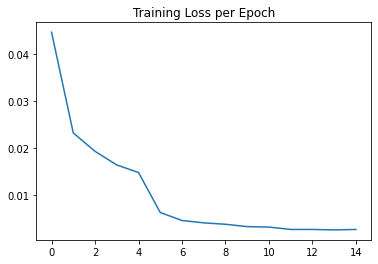

In [21]:
plt.title("Training Loss per Epoch")
plt.plot(train_loss_list_epochs)

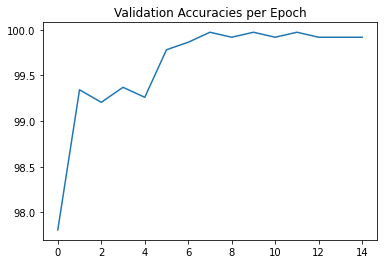

In [22]:
plt.title("Validation Accuracies per Epoch")
plt.plot(val_acc_list_epochs)

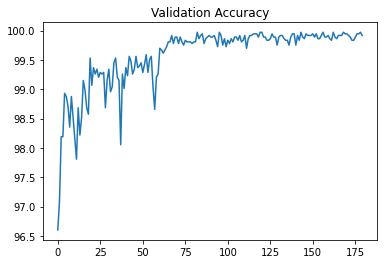

In [23]:
plt.title("Validation Accuracy")
plt.plot(val_acc_list)
plt.show()

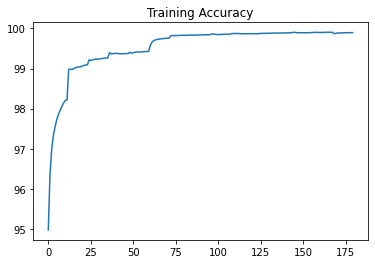

In [24]:
plt.title("Training Accuracy")
plt.plot(train_acc_list)
plt.show()

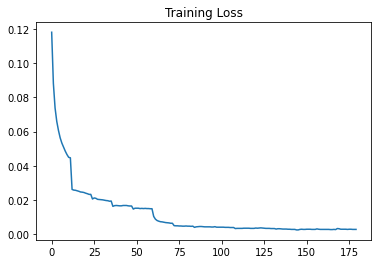

In [25]:
plt.title("Training Loss")
plt.plot(train_loss_list)
plt.show()

# Testing

In [26]:
test_start = time.time()
gans = os.listdir("./CNN_synth_testset")
test_accs = []
for gan in gans: #tqdm(gans):
    subdirs = os.listdir("./CNN_synth_testset/" + gan)
    if len(subdirs) == 2:
        gan_dataset = datasets.ImageFolder("./CNN_synth_testset/" + gan, transform=transform_test)
    else:
        gan_datasets = [datasets.ImageFolder("./CNN_synth_testset/" + gan + "/" + cat, transform=transform_test) for cat in subdirs]
        gan_dataset = torch.utils.data.ConcatDataset(gan_datasets)
        
    gan_loader = torch.utils.data.DataLoader(gan_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    acc = validation_test_loop(device, wang_2020_model, gan_loader)

    print(gan,"=",acc,"%")
    
    test_accs.append(acc) 

print(" ")
print("Testing Time=",round((time.time()-test_start)/60.0,4)," minutes")

imle = 90.3962 %
stylegan = 85.4709 %
san = 52.3562 %
progan = 100.0 %
cyclegan = 83.4573 %
stylegan2 = 81.5425 %
deepfake = 58.9395 %
gaugan = 76.254 %
whichfaceisreal = 70.8984 %
seeingdark = 92.6562 %
crn = 90.1004 %
stargan = 93.8244 %
biggan = 66.9643 %
 
Testing Time= 21.944  minutes


<BarContainer object of 13 artists>

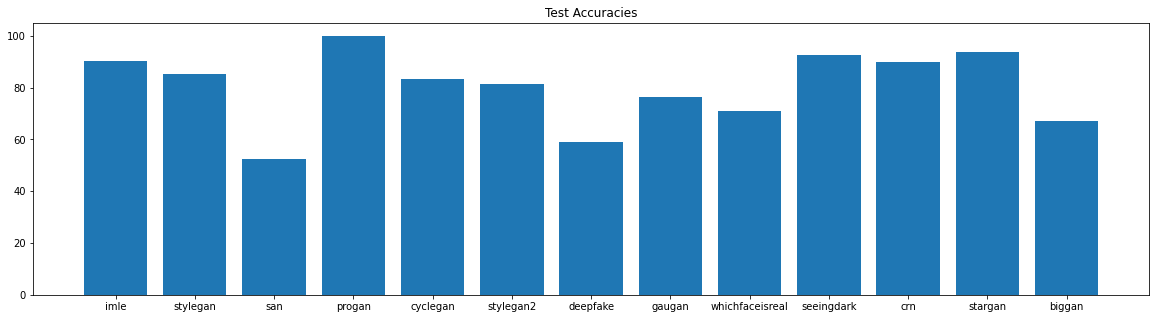

In [27]:
plt.figure(figsize=(20,5))
plt.title("Test Accuracies")
plt.bar(gans, test_accs)